### _Section 16.0:_ Load packages

In [1]:
import pandas as pd
import numpy as np

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

%matplotlib inline

/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### _Section 16.1:_ Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:
- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

#### Loading the data and setting the DateTimeIndex

In [2]:
data = pd.read_csv('./datasets/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### _16.2:_ Re-sample the data
> Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store (see slides for help)

In [31]:
# Filter to Store 1
store1_data = data[data.Store==1]

# Filter to store 1 sales and average over weeks
store1_sales = store1_data[['Weekly_Sales']].resample('W').mean()
store1_sales.head()

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


> Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe? (see slides for help)

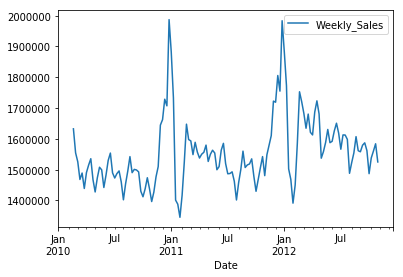

In [4]:
store1_sales[['Weekly_Sales']].rolling(window=3).mean().plot();

#### _16.3:_ Visualizing autocorrelations
> Compute the 1, 2, 52 autocorrelations for 'Weekly_Sales' with `.autocorr(lag=n)` and/or create an autocorrelation plot with `autocorrelation_plot()`

In [5]:
print('Autocorrelation 1: ', store1_sales['Weekly_Sales'].autocorr(1))
print('Autocorrelation 2: ', store1_sales['Weekly_Sales'].autocorr(2))
print('Autocorrelation 3: ', store1_sales['Weekly_Sales'].autocorr(3))
print('Autocorrelation 7: ', store1_sales['Weekly_Sales'].autocorr(7))
print('Autocorrelation 52: ', store1_sales['Weekly_Sales'].autocorr(52))

Autocorrelation 1:  0.3021582794113126
Autocorrelation 2:  0.12741313055390097
Autocorrelation 3:  0.059799235066717006
Autocorrelation 7:  0.043880179584754694
Autocorrelation 52:  0.8953760294777008


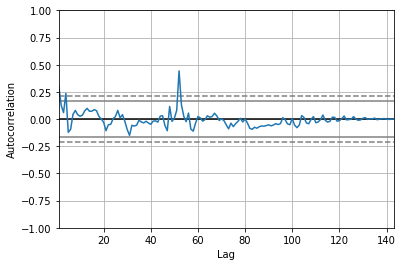

In [6]:
autocorrelation_plot(store1_sales['Weekly_Sales']);

> Interpretation:    
Components 1 and 2 seem particularly useful for **autoregression**, perhaps up to 4    
In the plot above, notice the spike around 52 - implying a yearly pattern!    
No _random spikes_, probably not much use for a **moving average model**

#### _16.4:_ Split the weekly sales data in a training and test set - using 75% of the data for training

In [9]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.75*n)]
test = store1_sales.Weekly_Sales[int(.75*n):]

#### _16.5:_ Create an AR(1) model on the training data and compute the mean absolute error of the predictions

In [10]:
model = sm.tsa.ARMA(train, (1, 0)).fit()
# OR `model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()`

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

Mean absolute error:  81839.33863162399


/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Thu, 10 May 2018   AIC                           2875.327
Time:                        13:14:47   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001       0.133       0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

#### _16.6:_ Plot the residuals - where are their significant errors

/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


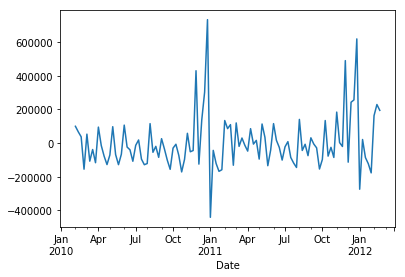

In [12]:
model.resid.plot();

/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


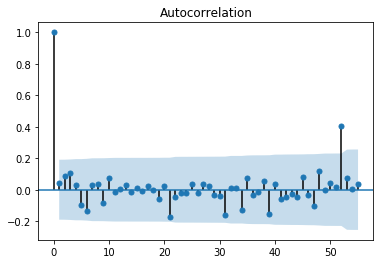

In [25]:
plot_acf(model.resid, lags=55);

#### _16.7:_  ARMA Demo:
Create an ARMA(1,1) (AR(1) + MA(1)) model on the training data and compute the mean absolute error of the predictions

In [14]:
model = sm.tsa.ARMA(train, (1, 1)).fit()
# OR `model = sm.tsa.ARIMA(train, (1, 0, 1)).fit()`

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

Mean absolute error:  80983.09282707066


/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 1)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.523
Date:                Thu, 10 May 2018   AIC                           2876.964
Time:                        13:14:48   BIC                           2887.656
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   2.43e+04     63.550      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.4824      0.266      1.816      0.072      -0.038       1.003
ma.L1.Weekly_Sales    -0.1856      0.296     -0.627      0.532      -0.766       0.395
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0731           +0.0000j            2.0731            0.0000
MA.1            5.3890           +0.0000j            5.3890            0.0000
-----------------------------------------------------------------------------
"""

#### _16.8:_ Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set

In [16]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

Mean absolute error:  81203.23437315048


/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Thu, 10 May 2018   AIC                           2876.963
Time:                        13:14:48   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003       0.108       0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548      -0.132       0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3587           +0.0000j            7.3587            0.5000
-----------------------------------------------------------------------------
"""

In [18]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Mean absolute error:  80502.88241336595


/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144111.441
Date:                Thu, 10 May 2018   AIC                           2863.563
Time:                        13:14:49   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.319      0.000    1.51e+06    1.58e+06
ar.L1.Weekly_Sales    -1.0397      0.090    -11.583      0.000      -1.216      -0.864
ar.L2.Weekly_Sales    -0.4701      0.087     -5.379      0.000      -0.641      -0.299
ma.L1.Weekly_Sales     1.4691      0.058     25.342      0.000       1.356       1.583
ma.L2.Weekly_Sales     0.9998      0.074     13.523      0.000       0.855       1.145
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.9509j            1.4586           -0.3870
AR.2           -1.1059           +0.9509j            1.4586            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

#### _16.9:_ Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance

In [20]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Mean absolute error:  77809.26421328615


/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1413.613
Method:                       css-mle   S.D. of innovations         142932.725
Date:                Thu, 10 May 2018   AIC                           2841.225
Time:                        13:14:50   BIC                           2859.869
Sample:                    02-14-2010   HQIC                          2848.782
                         - 02-19-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  582.8889    621.359      0.938      0.350    -634.952    1800.730
ar.L1.D.Weekly_Sales    -1.0486      0.090    -11.613      0.000      -1.226      -0.872
ar.L2.D.Weekly_Sales    -0.4788      0.088     -5.454      0.000      -0.651      -0.307
ma.L1.D.Weekly_Sales     0.4694      0.109      4.318      0.000       0.256       0.682
ma.L2.D.Weekly_Sales    -0.4693      0.140     -3.345      0.001      -0.744      -0.194
ma.L3.D.Weekly_Sales    -0.9998      0.117     -8.560      0.000      -1.229      -0.771
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0950           -0.9431j            1.4452           -0.3868
AR.2           -1.0950           +0.9431j            1.4452            0.3868
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.7348           -0.6784j            1.0001           -0.3813
MA.3           -0.7348           +0.6784j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

/Users/dat-44pt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


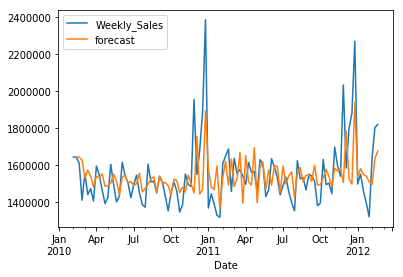

In [53]:
fig, ax = plt.subplots()
ax = train.plot(ax=ax)

fig = model.plot_predict(1, len(train)-1, ax=ax, plot_insample=False)